<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Clean-Character-Data" data-toc-modified-id="Load-Clean-Character-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Clean Character Data</a></span></li><li><span><a href="#Fit-Baseline-GAN-(Unconditional)" data-toc-modified-id="Fit-Baseline-GAN-(Unconditional)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit Baseline GAN (Unconditional)</a></span></li></ul></div>

## Load Clean Character Data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import tensorflow
from tensorflow.python.keras.layers import Input, Reshape, Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import initializers

In [4]:
#import clean 'j' and 'a' chars from EDA Phase
j_char_matrix = np.load('j_chars.npy')
a_char_matrix = np.load('a_chars.npy')

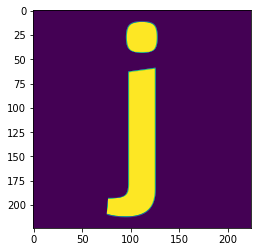

In [5]:
first_j = j_char_matrix[0]
plt.imshow(first_j)
plt.show()

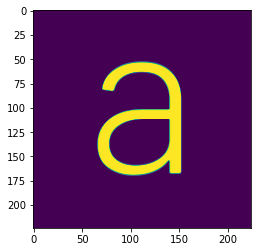

In [6]:
first_a = a_char_matrix[0]
plt.imshow(first_a)
plt.show()

In [10]:
print(first_a.shape)
print(a_char_matrix.shape)

(224, 224, 1)
(3631, 224, 224, 1)


## Fit Baseline GAN (Unconditional)

In [20]:
#define discriminator model
def define_discriminator(in_shape=(224, 224, 1)):
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #Downsample again
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #Classify
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    #Compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
#define generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128*56*56
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((56, 56, 128)))
    #upsample
    model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #upsample again
    model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    #generate
    model.add(Conv2D(1, kernel_size=(4, 4), activation='tanh'))
    return model

In [14]:
#define combined generator and discriminator
def define_gan(generator, descriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    #compile
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [30]:
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))
    return X, y

In [36]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [39]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [42]:
#train generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=16):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #summarize loss
            print('>%d, %d%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss_2, g_loss))
    #save generator
    g_model.save('generator.h5')

In [43]:
#test with 'a' characters
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = a_char_matrix

In [ ]:
#train
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 1226, d1=0.700, d2=0.707, g=0.787
>1, 2226, d1=0.029, d2=0.592, g=1.178
>1, 3226, d1=0.004, d2=0.314, g=1.927
>1, 4226, d1=0.000, d2=0.141, g=3.298
>1, 5226, d1=0.001, d2=0.036, g=5.581
>1, 6226, d1=0.085, d2=0.031, g=6.580
>1, 7226, d1=0.243, d2=0.844, g=13.497
>1, 8226, d1=0.000, d2=0.000, g=26.991
>1, 9226, d1=0.000, d2=0.000, g=40.008
>1, 10226, d1=0.009, d2=0.000, g=31.880
>1, 11226, d1=1.160, d2=0.000, g=19.292
>1, 12226, d1=0.000, d2=0.001, g=12.080
>1, 13226, d1=0.000, d2=0.040, g=3.811
>1, 14226, d1=0.000, d2=1.192, g=2.662
>1, 15226, d1=1.046, d2=0.409, g=4.223
>1, 16226, d1=0.000, d2=0.021, g=7.355
>1, 17226, d1=0.000, d2=0.001, g=9.939
>1, 18226, d1=0.000, d2=0.000, g=12.251
>1, 19226, d1=0.000, d2=0.000, g=13.536
>1, 20226, d1=0.012, d2=0.000, g=13.372
>1, 21226, d1=0.000, d2=0.000, g=12.768
>1, 22226, d1=0.000, d2=0.000, g=11.179
>1, 23226, d1=0.000, d2=0.000, g=8.687
>1, 24226, d1=0.000, d2=0.052, g=7.638
>1, 25226, d1=0.000, d2=1.869, g=9.135
>1, 26226, d1=0.000, d2

>1, 188226, d1=1.374, d2=0.001, g=7.728
>1, 189226, d1=0.000, d2=0.086, g=14.187
>1, 190226, d1=0.000, d2=0.003, g=7.707
>1, 191226, d1=0.000, d2=0.050, g=9.435
>1, 192226, d1=0.000, d2=0.001, g=11.354
>1, 193226, d1=0.687, d2=0.027, g=6.978
>1, 194226, d1=0.000, d2=0.041, g=5.834
>1, 195226, d1=0.039, d2=0.234, g=6.934
>1, 196226, d1=0.005, d2=0.035, g=9.706
>1, 197226, d1=0.001, d2=0.017, g=10.168
>1, 198226, d1=2.707, d2=0.022, g=9.747
>1, 199226, d1=0.002, d2=0.019, g=4.672
>1, 200226, d1=0.001, d2=0.045, g=5.505
>1, 201226, d1=0.102, d2=0.052, g=5.942
>1, 202226, d1=3.784, d2=0.654, g=7.106
>1, 203226, d1=0.004, d2=0.453, g=8.072
>1, 204226, d1=0.045, d2=0.022, g=9.389
>1, 205226, d1=1.089, d2=0.074, g=5.273
>1, 206226, d1=0.121, d2=0.523, g=7.847
>1, 207226, d1=1.277, d2=0.280, g=3.999
>1, 208226, d1=0.473, d2=1.707, g=4.952
>1, 209226, d1=1.688, d2=0.064, g=5.891
>1, 210226, d1=1.435, d2=0.256, g=2.729
>1, 211226, d1=0.054, d2=0.529, g=2.670
>1, 212226, d1=0.005, d2=0.064, g=5.5

>2, 170226, d1=0.046, d2=0.031, g=4.344
>2, 171226, d1=0.012, d2=0.347, g=4.829
>2, 172226, d1=0.048, d2=0.112, g=5.319
>2, 173226, d1=0.127, d2=0.060, g=5.062
>2, 174226, d1=0.139, d2=0.025, g=3.291
>2, 175226, d1=0.056, d2=0.217, g=3.733
>2, 176226, d1=0.074, d2=0.261, g=4.374
>2, 177226, d1=0.307, d2=0.024, g=3.488
>2, 178226, d1=0.367, d2=0.343, g=1.333
>2, 179226, d1=0.080, d2=0.604, g=3.593
>2, 180226, d1=0.226, d2=0.013, g=6.089
>2, 181226, d1=0.764, d2=0.006, g=2.682
>2, 182226, d1=0.010, d2=0.764, g=2.620
>2, 183226, d1=0.016, d2=0.009, g=5.194
>2, 184226, d1=0.003, d2=0.031, g=5.430
>2, 185226, d1=0.026, d2=0.051, g=6.697
>2, 186226, d1=0.031, d2=0.054, g=6.071
>2, 187226, d1=0.094, d2=0.011, g=3.893
>2, 188226, d1=0.065, d2=0.142, g=4.891
>2, 189226, d1=0.414, d2=0.443, g=3.332
>2, 190226, d1=0.011, d2=0.258, g=4.108
>2, 191226, d1=0.392, d2=0.124, g=4.433
>2, 192226, d1=0.128, d2=0.095, g=4.496
>2, 193226, d1=0.377, d2=0.026, g=3.123
>2, 194226, d1=0.008, d2=0.186, g=3.597


>3, 152226, d1=0.082, d2=0.372, g=5.175
>3, 153226, d1=0.222, d2=0.033, g=5.882
>3, 154226, d1=0.775, d2=0.061, g=2.666
>3, 155226, d1=0.172, d2=0.758, g=2.890
>3, 156226, d1=0.034, d2=0.154, g=3.644
>3, 157226, d1=0.870, d2=0.565, g=2.748
>3, 158226, d1=0.027, d2=0.182, g=2.603
>3, 159226, d1=0.061, d2=0.209, g=4.754
>3, 160226, d1=0.703, d2=0.013, g=4.556
>3, 161226, d1=0.357, d2=0.296, g=1.917
>3, 162226, d1=0.048, d2=0.204, g=2.806
>3, 163226, d1=0.044, d2=0.219, g=4.376
>3, 164226, d1=0.410, d2=0.037, g=4.128
>3, 165226, d1=0.358, d2=0.069, g=2.275
>3, 166226, d1=0.032, d2=0.605, g=3.143
>3, 167226, d1=0.070, d2=0.071, g=5.443
>3, 168226, d1=0.941, d2=0.098, g=3.297
>3, 169226, d1=0.080, d2=0.345, g=1.654
>3, 170226, d1=0.046, d2=0.371, g=3.143
>3, 171226, d1=0.086, d2=0.082, g=4.770
>3, 172226, d1=0.915, d2=0.278, g=2.102
>3, 173226, d1=0.018, d2=0.858, g=4.120
>3, 174226, d1=0.111, d2=0.021, g=5.920
>3, 175226, d1=1.033, d2=0.030, g=3.331
>3, 176226, d1=0.036, d2=0.609, g=2.556
